<h1 style="text-align: center;">Project Notebook</h1>

In [12]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
print(os.getcwd())
import shutil
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import numpy as np
import argparse
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import torch.nn.functional as F
from tqdm import tqdm
import torchvision.models as models
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
from PIL import Image

D:\Users\natha\Desktop\Coding\Uni\comp9444\group project\Comp9444Proj1


<h2 style="text-align: center;">Introduction, Motivation and/or Problem Statement</h2>

Place the intro here

<h2 style="text-align: center;">Data Sources or RL Tasks</h2>

place the data source here

<h2 style="text-align: center;">Exploratory Analysis of Data or RL Tasks</h2>

The data provided was not given in a formatting which would allow the data to simply be provided to the neural network, so preprocessing steps must be taken to ensure that the model is able to receive the correct information. First, a pandas dataframe containing the metadata of the provided dataset was extracted, to allow the properties to be efficiently analysed and allow modifications to the dataset to be easily made. This was then transformed to a new folder, which stored a train, test and validation set, ready to be imported by torchvisions datasets module, allowing ease to preparation to be provided to the model. 

Through this analysis, it is found that the dataset provided is grouped by 2 main properties; the class of the image and its magnification. The distribution of the data and its associated classes and magnifications are shown below. It can be seen that there is a vast class imbalance which may result in difficulties in predicting certain classes, particularly those with small samples. 

In [14]:
# the original dataset
src_root = os.path.join(os.getcwd(), "EBH-HE-IDS")
# a midway dataset that stores its metadata information in a pandas dataframe
dst_root = os.path.join(os.getcwd(), "grouped_ds")

os.makedirs(dst_root, exist_ok=True)

df = pd.DataFrame()

for class_name in os.listdir(src_root):
    class_path = os.path.join(src_root, class_name)
    for root, dirs, files in os.walk(class_path):
        if len(dirs) == 0:
            magnification = int(list(root.split('\\'))[-1])
            instance = list(root.split('\\'))[-2]

            for i in range(len(files)):
                file_name = f'{class_name}_{magnification}_{instance}_{i}.jpg'
                data = pd.DataFrame([{
                    'class': class_name,
                    'magnification': magnification,
                    'file name': file_name
                }])
                df = pd.concat([df, data]).reset_index(drop=True)

                src_file = os.path.join(root, files[i])
                dst_file = os.path.join(dst_root, file_name)
                shutil.copy2(src_file, dst_file)

df.to_csv('metadata.csv')

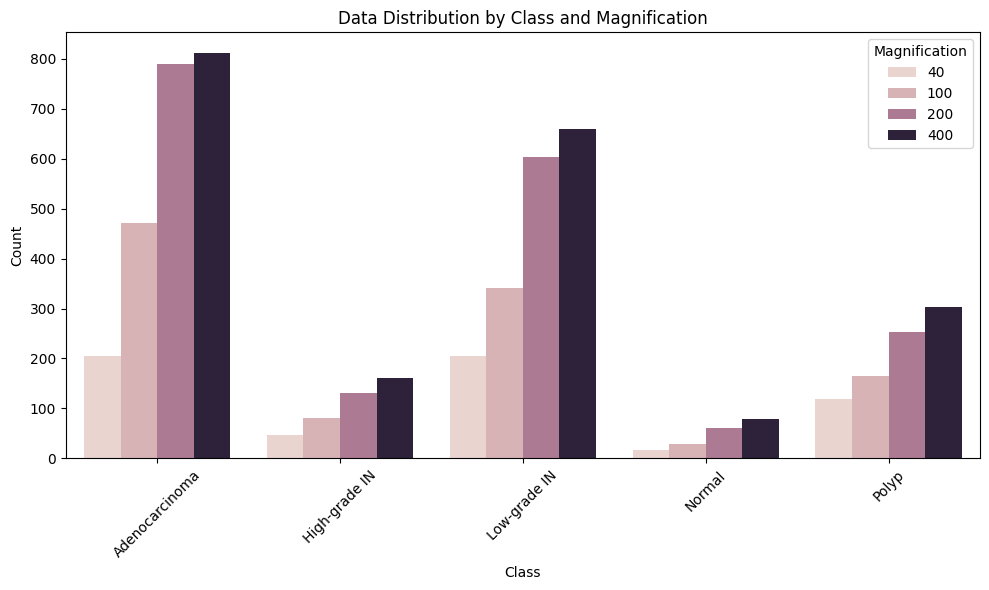

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="class", hue="magnification")
plt.title("Data Distribution by Class and Magnification")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend(title="Magnification")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
src_root = os.path.join(os.getcwd(), "grouped_ds")
dst_root = os.path.join(os.getcwd(), "dataset")

df = pd.read_csv("metadata.csv")

# can manipulate data below if needed - change the class distribution etc
# split dataset into train, val, test sets (80/10/10)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

splits = {
    'train': train_df,
    'val': val_df,
    'test': test_df
}

for split_name, split_df in splits.items():
    for class_name in np.unique(split_df['class']):
        class_data = split_df[split_df['class'] == class_name]

        class_folder = os.path.join(dst_root, split_name, class_name)
        os.makedirs(class_folder, exist_ok=True)

        for file_name in class_data['file name'].values:
            src_file = os.path.join(src_root, file_name)
            dst_file = os.path.join(class_folder, file_name)
            shutil.copy2(src_file, dst_file)

<h2 style="text-align: center;">Models and/or Methods</h2>

Overview of Model + Model Choices

Short description of loss functions

In [16]:
# -----------------------------
# Loss functions
# -----------------------------
def dice_loss(pred, target, epsilon=1e-6):
    pred = torch.softmax(pred, dim=1)
    target = F.one_hot(target, num_classes=pred.size(1)).permute(0, 3, 1, 2).float() \
        if target.ndim == 3 else F.one_hot(target, num_classes=pred.size(1)).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return 1 - (2. * intersection + epsilon) / (union + epsilon)

def focal_loss(pred, target, alpha=0.75, gamma=2):
    ce_loss = F.cross_entropy(pred, target, reduction='none')
    pt = torch.exp(-ce_loss)
    focal = alpha * (1 - pt) ** gamma * ce_loss
    return focal.mean()

def tversky_loss(pred, target, alpha=0.7, beta=0.3, epsilon=1e-6):
    pred = torch.softmax(pred, dim=1)
    target = F.one_hot(target, num_classes=pred.size(1)).float()
    tp = (pred * target).sum()
    fp = ((1 - target) * pred).sum()
    fn = (target * (1 - pred)).sum()
    return 1 - (tp + epsilon) / (tp + alpha * fp + beta * fn + epsilon)

def combo_loss(pred, target):
    return 0.5 * focal_loss(pred, target) + 0.5 * dice_loss(pred, target)

def focal_tversky_combo(pred, target):
    return 0.5 * focal_loss(pred, target) + 0.5 * tversky_loss(pred, target)

def select_loss(loss_type):
    if loss_type == "dice":
        return dice_loss
    elif loss_type == "focal":
        return focal_loss
    elif loss_type == "tversky":
        return tversky_loss
    elif loss_type == "focal+dice":
        return combo_loss
    elif loss_type == "focal+tversky":
        return focal_tversky_combo
    else:
        raise ValueError(f"Unsupported loss function: {loss_type}")


resnet50

In [17]:
# -----------------------------
# resnet50
# -----------------------------
def get_resnet_classifier(num_classes=5, pretrained=True):
    model = models.resnet50(weights="IMAGENET1K_V1" if pretrained else None)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

Training Loop

In [42]:
# -----------------------------
# Training Loop with Args
# -----------------------------
def train_model(model, train_loader, val_loader, device, args, class_names):
    model = model.to(device)

    # ✅ Select optimizer based on args
    if args["optimizer"] == "adam":
        optimizer = optim.Adam(model.parameters(), lr=args["lr"])
    elif args["optimizer"] == "adamw":
        optimizer = optim.AdamW(model.parameters(), lr=args["lr"], weight_decay=1e-4)
    elif args["optimizer"] == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=args["lr"], momentum=0.9, weight_decay=1e-4)
    else:
        raise ValueError(f"Unsupported optimizer: {args['optimizer']}")

    # ✅ Select loss from args
    loss_fn = select_loss(args["loss"])

    history = {
        "acc": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "per_class": {i: {"precision": [], "recall": [], "f1": []} for i in range(len(class_names))}
    }

    best_acc = 0
    best_y_true = []
    best_y_pred = []

    for epoch in range(args["epochs"]):
        # -----------------------------
        # Training
        # -----------------------------
        model.train()
        total_loss, correct, total = 0, 0, 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{args['epochs']} [Train]", unit="batch")
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({"loss": f"{loss.item():.4f}",
                              "acc": f"{(correct / total):.4f}"})

        train_acc = correct / total
        print(f"[Train] Epoch {epoch+1}: Loss={total_loss/total:.4f}, Acc={train_acc:.4f}")

        # -----------------------------
        # Validation
        # -----------------------------
        model.eval()
        y_true, y_pred = [], []
        val_loss, val_correct, val_total = 0, 0, 0
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{args['epochs']} [Val]", unit="batch")
        with torch.no_grad():
            for imgs, labels in pbar_val:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = loss_fn(outputs, labels)

                preds = outputs.argmax(1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

                val_loss += loss.item() * labels.size(0)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                pbar_val.set_postfix({"loss": f"{loss.item():.4f}",
                                      "acc": f"{(val_correct/val_total):.4f}"})

        # -----------------------------
        # Metrics Calculation
        # -----------------------------
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
            y_true, y_pred, labels=list(range(len(class_names))), average="macro", zero_division=0
        )
        acc = np.mean(np.array(y_true) == np.array(y_pred))
        history["acc"].append(acc)
        history["precision"].append(precision_macro)
        history["recall"].append(recall_macro)
        history["f1"].append(f1_macro)

        # Per-class metrics
        precision_cls, recall_cls, f1_cls, _ = precision_recall_fscore_support(
            y_true, y_pred, labels=list(range(len(class_names))), zero_division=0
        )
        for i, cls_name in enumerate(class_names):
            history["per_class"][i]["precision"].append(precision_cls[i])
            history["per_class"][i]["recall"].append(recall_cls[i])
            history["per_class"][i]["f1"].append(f1_cls[i])

        print(
            f"[Val] Epoch {epoch + 1}: Acc={acc:.4f}, Precision={precision_macro:.4f}, Recall={recall_macro:.4f}, F1={f1_macro:.4f}")

        # Save best model & confusion matrix
        if acc > best_acc:
            best_acc = acc
            best_y_true = y_true
            best_y_pred = y_pred

            print(f"✅ Best model saved at epoch {epoch+1} with Acc={acc:.4f}")

    return history, best_y_true, best_y_pred

Args

In [43]:
import argparse, sys, torch

def get_args():
    parser = argparse.ArgumentParser(description="Train ResNet Classifier on Custom Dataset")
    parser.add_argument("--data_dir", type=str, required=True, help="Path to dataset")
    parser.add_argument("--epochs", type=int, default=50, help="Number of training epochs")
    parser.add_argument("--batch_size", type=int, default=16, help="Batch size for training")
    parser.add_argument("--lr", type=float, default=1e-4, help="Learning rate")
    parser.add_argument("--optimizer", type=str, default="adamw", 
                        choices=["adam", "adamw", "sgd"], help="Optimizer type")
    parser.add_argument("--loss", type=str, default="focal+tversky",
                        choices=["dice", "focal", "tversky", "focal+dice", "focal+tversky"],
                        help="Loss function")
    parser.add_argument("--img_size", type=int, default=224, help="Input image size (square)")
    parser.add_argument("--num_workers", type=int, default=4, help="Number of DataLoader workers")
    parser.add_argument("--save_dir", type=str, default="results", help="Directory to save outputs")
    parser.add_argument("--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu",
                        help="Training device")

    args = parser.parse_args(sys.argv[1:])  # works in Jupyter after cleaning sys.argv in launcher
    return args


In [44]:
dataset_path = os.path.abspath(os.path.join(os.getcwd(), "dataset"))

args = {
    "data_dir": dataset_path,
    "epochs": 10,
    "batch_size": 8,
    "lr": 5e-4,
    "img_size": 512,
    "optimizer": "adamw",
    "num_workers": 4,
    "save_dir": "runs",
    "loss": "focal+dice"
}

args["device"] = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([
    transforms.Resize((args["img_size"], args["img_size"])),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(os.path.join(args["data_dir"], "train"), transform=transform)
val_data   = datasets.ImageFolder(os.path.join(args["data_dir"], "val"), transform=transform)

train_loader = DataLoader(train_data,
                          batch_size=args["batch_size"],
                          shuffle=True,
                          num_workers=args["num_workers"],
                          pin_memory=True)

val_loader = DataLoader(val_data,
                          batch_size=args["batch_size"],
                          shuffle=True,
                          num_workers=args["num_workers"],
                          pin_memory=True)

class_names = train_data.classes
print("Classes:", class_names)

device = torch.device(args["device"])
model = get_resnet_classifier(num_classes=len(class_names))

print(f"Using loss function: {args['loss']}")
loss_fn = select_loss(args["loss"])

history, y_true, y_pred = train_model(model, train_loader, val_loader, device, args, class_names)

Classes: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
Using loss function: focal+dice


Epoch 1/10 [Train]: 100%|████████████████████████████████| 554/554 [02:19<00:00,  3.98batch/s, loss=0.8011, acc=0.7150]


[Train] Epoch 1: Loss=0.3834, Acc=0.7150


Epoch 1/10 [Val]: 100%|████████████████████████████████████| 70/70 [00:19<00:00,  3.66batch/s, loss=1.5437, acc=0.7975]


[Val] Epoch 1: Acc=0.7975, Precision=0.5604, Recall=0.5305, F1=0.5206
✅ Best model saved at epoch 1 with Acc=0.7975


Epoch 2/10 [Train]: 100%|████████████████████████████████| 554/554 [02:16<00:00,  4.05batch/s, loss=0.1046, acc=0.7797]


[Train] Epoch 2: Loss=0.2909, Acc=0.7797


Epoch 2/10 [Val]: 100%|████████████████████████████████████| 70/70 [00:19<00:00,  3.68batch/s, loss=0.0187, acc=0.7993]


[Val] Epoch 2: Acc=0.7993, Precision=0.6571, Recall=0.6942, F1=0.6457
✅ Best model saved at epoch 2 with Acc=0.7993


Epoch 3/10 [Train]: 100%|████████████████████████████████| 554/554 [02:16<00:00,  4.05batch/s, loss=1.3056, acc=0.8206]


[Train] Epoch 3: Loss=0.2336, Acc=0.8206


Epoch 3/10 [Val]: 100%|████████████████████████████████████| 70/70 [00:20<00:00,  3.43batch/s, loss=0.0032, acc=0.8427]


[Val] Epoch 3: Acc=0.8427, Precision=0.8502, Recall=0.6053, F1=0.6095
✅ Best model saved at epoch 3 with Acc=0.8427


Epoch 4/10 [Train]: 100%|████████████████████████████████| 554/554 [02:21<00:00,  3.91batch/s, loss=1.2464, acc=0.8276]


[Train] Epoch 4: Loss=0.2152, Acc=0.8276


Epoch 4/10 [Val]: 100%|████████████████████████████████████| 70/70 [00:19<00:00,  3.59batch/s, loss=0.0276, acc=0.8174]


[Val] Epoch 4: Acc=0.8174, Precision=0.7317, Recall=0.7201, F1=0.7211


Epoch 5/10 [Train]: 100%|████████████████████████████████| 554/554 [02:19<00:00,  3.98batch/s, loss=1.0157, acc=0.8452]


[Train] Epoch 5: Loss=0.1958, Acc=0.8452


Epoch 5/10 [Val]: 100%|████████████████████████████████████| 70/70 [00:19<00:00,  3.51batch/s, loss=0.0580, acc=0.8373]


[Val] Epoch 5: Acc=0.8373, Precision=0.7476, Recall=0.7310, F1=0.7326


Epoch 6/10 [Train]: 100%|████████████████████████████████| 554/554 [02:19<00:00,  3.96batch/s, loss=0.2025, acc=0.8490]


[Train] Epoch 6: Loss=0.1921, Acc=0.8490


Epoch 6/10 [Val]: 100%|████████████████████████████████████| 70/70 [00:19<00:00,  3.55batch/s, loss=0.4802, acc=0.8752]


[Val] Epoch 6: Acc=0.8752, Precision=0.8257, Recall=0.7088, F1=0.7332
✅ Best model saved at epoch 6 with Acc=0.8752


Epoch 7/10 [Train]: 100%|████████████████████████████████| 554/554 [02:19<00:00,  3.97batch/s, loss=0.0987, acc=0.8701]


[Train] Epoch 7: Loss=0.1675, Acc=0.8701


Epoch 7/10 [Val]: 100%|████████████████████████████████████| 70/70 [00:20<00:00,  3.40batch/s, loss=0.3509, acc=0.8174]


[Val] Epoch 7: Acc=0.8174, Precision=0.7939, Recall=0.6683, F1=0.6496


Epoch 8/10 [Train]: 100%|████████████████████████████████| 554/554 [02:20<00:00,  3.93batch/s, loss=0.1313, acc=0.8852]


[Train] Epoch 8: Loss=0.1493, Acc=0.8852


Epoch 8/10 [Val]: 100%|████████████████████████████████████| 70/70 [00:19<00:00,  3.60batch/s, loss=0.0007, acc=0.8427]


[Val] Epoch 8: Acc=0.8427, Precision=0.6875, Recall=0.6603, F1=0.6682


Epoch 9/10 [Train]: 100%|████████████████████████████████| 554/554 [02:18<00:00,  4.00batch/s, loss=0.0325, acc=0.8863]


[Train] Epoch 9: Loss=0.1465, Acc=0.8863


Epoch 9/10 [Val]: 100%|████████████████████████████████████| 70/70 [00:19<00:00,  3.66batch/s, loss=0.5596, acc=0.8553]


[Val] Epoch 9: Acc=0.8553, Precision=0.6457, Recall=0.5966, F1=0.5876


Epoch 10/10 [Train]: 100%|███████████████████████████████| 554/554 [02:17<00:00,  4.02batch/s, loss=0.2225, acc=0.8999]


[Train] Epoch 10: Loss=0.1304, Acc=0.8999


Epoch 10/10 [Val]: 100%|███████████████████████████████████| 70/70 [00:19<00:00,  3.63batch/s, loss=0.0392, acc=0.8481]

[Val] Epoch 10: Acc=0.8481, Precision=0.7574, Recall=0.7447, F1=0.7358


2 EfficientNet-B0

In [6]:
import argparse, copy, time
from pathlib import Path
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.metrics import classification_report, confusion_matrix


DATA_ROOT = Path(os.path.join(os.getcwd(), "dataset")) 
IMG_SIZE   = 224
MEAN, STD  = [0.485,0.456,0.406], [0.229,0.224,0.225]
BATCH      = 32
NUM_WORKERS = 4     
PIN_MEMORY  = False  # True on CUDA GPUs

def get_loaders(batch=BATCH):
    train_tfms = transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE,(0.8,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(0.3),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.1,0.1,0.1,0.05),
        transforms.ToTensor(), transforms.Normalize(MEAN,STD)])
    eval_tfms  = transforms.Compose([
        transforms.Resize(int(IMG_SIZE*1.14)), transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(), transforms.Normalize(MEAN,STD)])
    train_ds = datasets.ImageFolder(DATA_ROOT/"train", train_tfms)
    val_ds   = datasets.ImageFolder(DATA_ROOT/"val",   eval_tfms)
    test_ds  = datasets.ImageFolder(DATA_ROOT/"test",  eval_tfms)
    kw = dict(batch_size=batch, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    return (DataLoader(train_ds, shuffle=True,  **kw),
            DataLoader(val_ds,   shuffle=False, **kw),
            DataLoader(test_ds,  shuffle=False, **kw),
            train_ds.classes)

model&train

In [7]:
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps"  if torch.backends.mps.is_available()
                      else "cpu") 

train_dl, val_dl, test_dl, classes = get_loaders()

weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(classes))
model.to(device)

EPOCHS   = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

history = {"train_acc":[], "val_acc":[], "train_loss":[], "val_loss":[]}
best_w, best_acc = copy.deepcopy(model.state_dict()), 0.0

for epoch in range(EPOCHS):
    t0 = time.time(); model.train()
    tr_loss = correct = total = 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x); loss = criterion(out, y)
        loss.backward(); optimizer.step()
        tr_loss += loss.item()*x.size(0)
        correct += out.argmax(1).eq(y).sum().item(); total += y.size(0)
    tr_loss /= total; tr_acc = correct/total

    # validation
    model.eval(); val_loss = correct = total = 0
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            out = model(x); val_loss += criterion(out, y).item()*x.size(0)
            correct += out.argmax(1).eq(y).sum().item(); total += y.size(0)
    val_loss /= total; val_acc = correct/total
    scheduler.step()

    history["train_acc"].append(tr_acc); history["val_acc"].append(val_acc)
    history["train_loss"].append(tr_loss); history["val_loss"].append(val_loss)

    if val_acc > best_acc:
        best_acc, best_w = val_acc, copy.deepcopy(model.state_dict())

    print(f"Ep {epoch+1:02}/{EPOCHS} "
          f"tr_acc={tr_acc:.3f} val_acc={val_acc:.3f} "
          f"({time.time()-t0:.1f}s)")

model.load_state_dict(best_w)

Ep 01/10 tr_acc=0.716 val_acc=0.857 (196.1s)
Ep 02/10 tr_acc=0.858 val_acc=0.879 (96.2s)
Ep 03/10 tr_acc=0.891 val_acc=0.902 (96.8s)
Ep 04/10 tr_acc=0.911 val_acc=0.902 (95.2s)
Ep 05/10 tr_acc=0.920 val_acc=0.897 (95.1s)
Ep 06/10 tr_acc=0.936 val_acc=0.901 (92.5s)
Ep 07/10 tr_acc=0.947 val_acc=0.895 (96.1s)
Ep 08/10 tr_acc=0.953 val_acc=0.902 (94.9s)
Ep 09/10 tr_acc=0.952 val_acc=0.904 (103.4s)
Ep 10/10 tr_acc=0.954 val_acc=0.910 (100.9s)


<All keys matched successfully>

Confusion matrix and class accuracy

In [ ]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for x, y in test_dl:
        logits = model(x.to(device))
        y_true.extend(y.numpy())
        y_pred.extend(logits.argmax(1).cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:")
print(cm)

acc_per_class = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, acc_per_class):
    print(f"{cls:<15s}: {acc*100:5.1f}%")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history['val_acc'],       label='EffNet-B0')
plt.xlabel('Epoch'); plt.ylabel('Val Accuracy'); plt.legend(); plt.grid(True)
plt.title('Validation Accuracy – Model Comparison')
plt.show()

Data augmentation was also used in order to address the class imbalanced identified in the exploratory analysis of the data in the previous section. The low class counts of high grade IN, normal and polyp classes resulted in slight decreases in the accuracy of this model. Applying data augmentation techniques in order to create new instances of these underrepresented classes allowed the model to more effectively capture the nature of these classes and result in a better performance. 

In [47]:
src_root = os.path.join(os.getcwd(), "grouped_ds")
dst_root = os.path.join(os.getcwd(), "augmented_dataset")

df = pd.read_csv("metadata.csv")

# can manipulate data below if needed - change the class distribution etc
# split dataset into train, val, test sets (80/10/10)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

splits = {
    'train': train_df,
    'val': val_df,
    'test': test_df
}

tansformation = v2.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15, expand=False)
])

n_augments = 1

for split_name, split_df in splits.items():
    for class_name in np.unique(split_df['class']):
        class_data = split_df[split_df['class'] == class_name]

        class_folder = os.path.join(dst_root, split_name, class_name)
        os.makedirs(class_folder, exist_ok=True)

        for file_name in class_data['file name'].values:
            src_file = os.path.join(src_root, file_name)
            dst_file = os.path.join(class_folder, file_name)
            shutil.copy2(src_file, dst_file)

            # special case for train dataset - data augmentation
            # addressing only the classes with low class counts
            if split_name == 'train':
                if class_name == "High-grade IN" or class_name == "Normal" or class_name == "Polyp":
                    class_folder = os.path.join(dst_root, split_name, class_name)
                    image = Image.open(src_file).convert("RGB")
            
                    for i in range(n_augments):
                        augmented_img = tansformation(image)
                        aug_file_name = f"{os.path.splitext(file_name)[0]}_aug{i}{os.path.splitext(file_name)[1]}"
                        aug_file_path = os.path.join(class_folder, aug_file_name)
                        augmented_img.save(aug_file_path)

Launching with: ['--data_dir', 'D:\\Users\\natha\\Desktop\\Coding\\Uni\\comp9444\\group project\\Comp9444Proj1\\augmented_dataset', '--epochs', '10', '--batch_size', '8', '--lr', '5e-4', '--img_size', '512', '--optimizer', 'adamw', '--num_workers', '4', '--save_dir', 'runs', '--loss', 'focal+dice']
✅ Using dataset: D:\Users\natha\Desktop\Coding\Uni\comp9444\group project\Comp9444Proj1\augmented_dataset
Classes: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
Using loss function: focal+dice


Epoch 1/10 [Train]: 100%|████████████████████████████████| 698/698 [03:06<00:00,  3.75batch/s, loss=0.2883, acc=0.7168]


[Train] Epoch 1: Loss=0.3649, Acc=0.7168


Epoch 1/10 [Val]: 100%|████████████████████████████████████| 70/70 [00:20<00:00,  3.43batch/s, loss=0.3431, acc=0.8210]


[Val] Epoch 1: Acc=0.8210, Precision=0.6038, Recall=0.5416, F1=0.5294
✅ Best model saved at epoch 1 with Acc=0.8210


Epoch 2/10 [Train]: 100%|████████████████████████████████| 698/698 [02:49<00:00,  4.12batch/s, loss=0.3256, acc=0.7967]


[Train] Epoch 2: Loss=0.2638, Acc=0.7967


Epoch 2/10 [Val]: 100%|████████████████████████████████████| 70/70 [00:19<00:00,  3.60batch/s, loss=0.3113, acc=0.8445]


[Val] Epoch 2: Acc=0.8445, Precision=0.7171, Recall=0.7220, F1=0.7064
✅ Best model saved at epoch 2 with Acc=0.8445


Epoch 3/10 [Train]: 100%|████████████████████████████████| 698/698 [02:51<00:00,  4.07batch/s, loss=0.0375, acc=0.8223]


[Train] Epoch 3: Loss=0.2234, Acc=0.8223


Epoch 3/10 [Val]: 100%|████████████████████████████████████| 70/70 [00:19<00:00,  3.62batch/s, loss=0.1700, acc=0.8716]


[Val] Epoch 3: Acc=0.8716, Precision=0.8150, Recall=0.7377, F1=0.7595
✅ Best model saved at epoch 3 with Acc=0.8716


Epoch 4/10 [Train]: 100%|████████████████████████████████| 698/698 [02:51<00:00,  4.08batch/s, loss=0.0428, acc=0.8524]


[Train] Epoch 4: Loss=0.1866, Acc=0.8524


Epoch 4/10 [Val]: 100%|████████████████████████████████████| 70/70 [00:19<00:00,  3.59batch/s, loss=0.1209, acc=0.8445]


[Val] Epoch 4: Acc=0.8445, Precision=0.8213, Recall=0.7033, F1=0.7436


Epoch 5/10 [Train]: 100%|████████████████████████████████| 698/698 [02:51<00:00,  4.08batch/s, loss=0.2355, acc=0.8595]


[Train] Epoch 5: Loss=0.1775, Acc=0.8595


Epoch 5/10 [Val]: 100%|████████████████████████████████████| 70/70 [00:19<00:00,  3.56batch/s, loss=0.6689, acc=0.7722]


[Val] Epoch 5: Acc=0.7722, Precision=0.6562, Recall=0.7134, F1=0.6157


Epoch 6/10 [Train]: 100%|████████████████████████████████| 698/698 [02:51<00:00,  4.07batch/s, loss=0.0739, acc=0.8717]


[Train] Epoch 6: Loss=0.1596, Acc=0.8717


Epoch 6/10 [Val]: 100%|████████████████████████████████████| 70/70 [00:19<00:00,  3.62batch/s, loss=0.0740, acc=0.8843]


[Val] Epoch 6: Acc=0.8843, Precision=0.7845, Recall=0.7699, F1=0.7752
✅ Best model saved at epoch 6 with Acc=0.8843


Epoch 7/10 [Train]: 100%|████████████████████████████████| 698/698 [02:51<00:00,  4.07batch/s, loss=0.0849, acc=0.8943]


[Train] Epoch 7: Loss=0.1437, Acc=0.8943


Epoch 7/10 [Val]: 100%|████████████████████████████████████| 70/70 [00:19<00:00,  3.61batch/s, loss=0.2047, acc=0.8590]


[Val] Epoch 7: Acc=0.8590, Precision=0.8252, Recall=0.6864, F1=0.7196


Epoch 8/10 [Train]: 100%|████████████████████████████████| 698/698 [02:51<00:00,  4.07batch/s, loss=0.0201, acc=0.8966]


[Train] Epoch 8: Loss=0.1336, Acc=0.8966


Epoch 8/10 [Val]: 100%|████████████████████████████████████| 70/70 [00:19<00:00,  3.62batch/s, loss=0.2007, acc=0.8770]


[Val] Epoch 8: Acc=0.8770, Precision=0.8314, Recall=0.7170, F1=0.7509


Epoch 9/10 [Train]: 100%|████████████████████████████████| 698/698 [02:51<00:00,  4.06batch/s, loss=0.0544, acc=0.9013]


[Train] Epoch 9: Loss=0.1260, Acc=0.9013


Epoch 9/10 [Val]: 100%|████████████████████████████████████| 70/70 [00:19<00:00,  3.59batch/s, loss=0.1032, acc=0.8752]


[Val] Epoch 9: Acc=0.8752, Precision=0.7958, Recall=0.7791, F1=0.7793


Epoch 10/10 [Train]: 100%|███████████████████████████████| 698/698 [02:52<00:00,  4.06batch/s, loss=0.0206, acc=0.9214]


[Train] Epoch 10: Loss=0.1020, Acc=0.9214


Epoch 10/10 [Val]: 100%|███████████████████████████████████| 70/70 [00:19<00:00,  3.59batch/s, loss=0.0420, acc=0.8535]


[Val] Epoch 10: Acc=0.8535, Precision=0.7344, Recall=0.7645, F1=0.7475


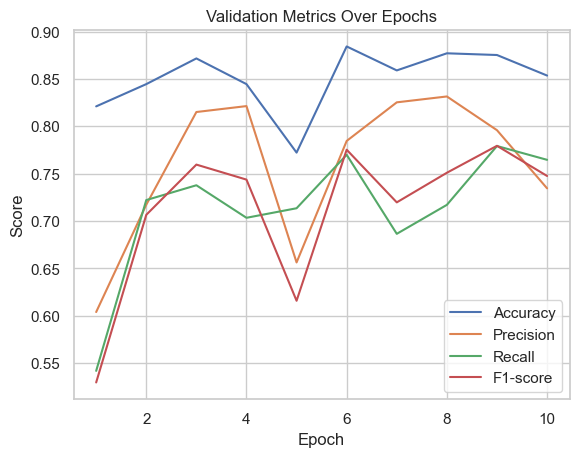

In [48]:
import sys, os

# clear Jupyter's own args
sys.argv = sys.argv[:1]

dataset_path = os.path.abspath(os.path.join(os.getcwd(), "augmented_dataset"))
if not os.path.isdir(dataset_path):
    raise RuntimeError(f"❌ Dataset folder not found at {dataset_path}")

sys.argv += [
    "--data_dir", dataset_path,
    "--epochs", "10",
    "--batch_size", "8",
    "--lr", "5e-4",
    "--img_size", "512",
    "--optimizer", "adamw",
    "--num_workers", "4",
    "--save_dir", "runs",
    "--loss", "focal+dice",  # ✅ matches parser
]

print("Launching with:", sys.argv[1:])
main()

<h2 style="text-align: center;">Results</h2>

In [67]:
# -----------------------------
# Metrics Plotting
# -----------------------------
def plot_metrics(history, save_dir=None, show_inline=True):
    epochs = range(1, len(history["acc"]) + 1)
    plt.figure()
    plt.plot(epochs, history["acc"], label="Accuracy")
    plt.plot(epochs, history["precision"], label="Precision")
    plt.plot(epochs, history["recall"], label="Recall")
    plt.plot(epochs, history["f1"], label="F1-score")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Validation Metrics Over Epochs")
    plt.legend()
    plt.grid(True)
    if save_dir:
        plt.savefig(os.path.join(save_dir, "metrics_curve.png"))
    if show_inline:
        plt.show()
    plt.close()


def plot_per_class_metrics(history, class_names, save_dir=None, show_inline=True):
    epochs = range(1, len(history["acc"]) + 1)

    for metric in ["precision", "recall", "f1"]:
        plt.figure(figsize=(8, 6))
        for i, cls_name in enumerate(class_names):
            plt.plot(epochs, history["per_class"][i][metric], label=cls_name)
        plt.xlabel("Epoch")
        plt.ylabel(metric.capitalize())
        plt.title(f"Per-Class {metric.capitalize()} Over Epochs")
        plt.legend()
        plt.grid(True)
        if save_dir:
            plt.savefig(os.path.join(save_dir, f"per_class_{metric}.png"))
        if show_inline:
            plt.show()
        plt.close()


def plot_confusion(y_true, y_pred, class_names, save_dir=None):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    if save_dir:
        plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
    if show_inline:
        plt.show()
    plt.close()

In [72]:
# -----------------------------
# Plotting
# -----------------------------
def plot_global(history, save_dir=None):
    epochs = range(1, len(history['train_loss'])+1)
    plt.figure()
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'],   label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curve'); plt.legend(); plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'loss_curve.png'))
    plt.close()

    plt.figure()
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'],   label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curve'); plt.legend(); plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'accuracy_curve.png'))
    plt.close()

Resnet50

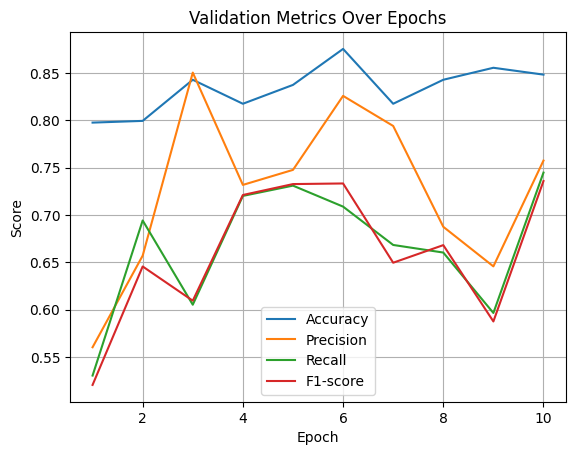

In [73]:
# Metrics
plot_metrics(history)

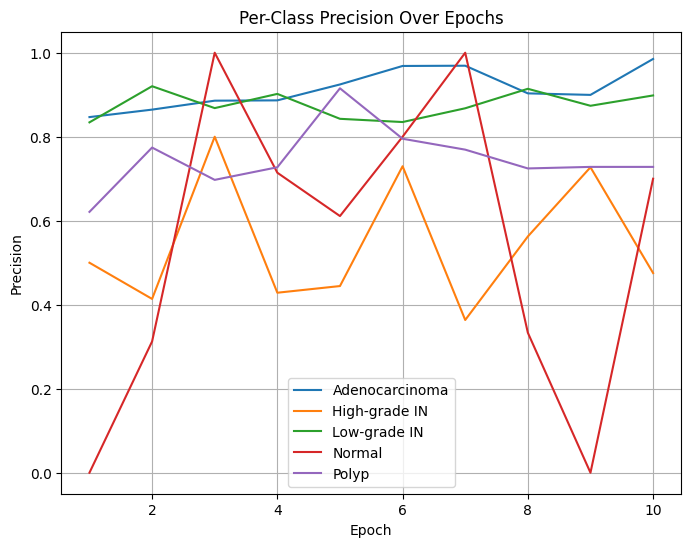

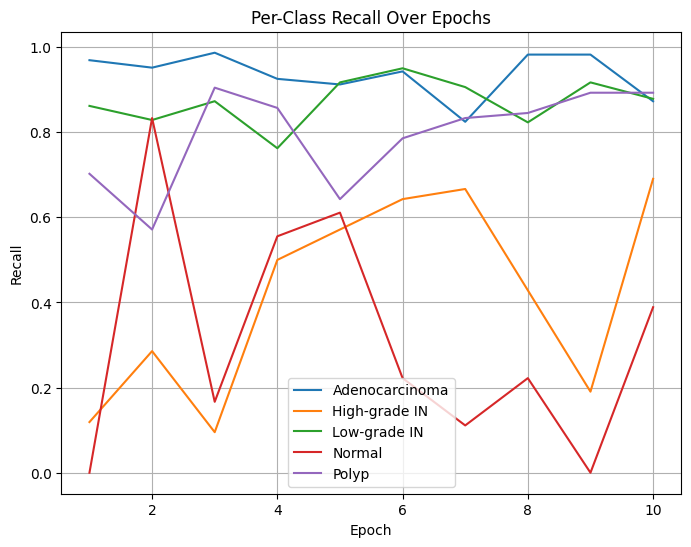

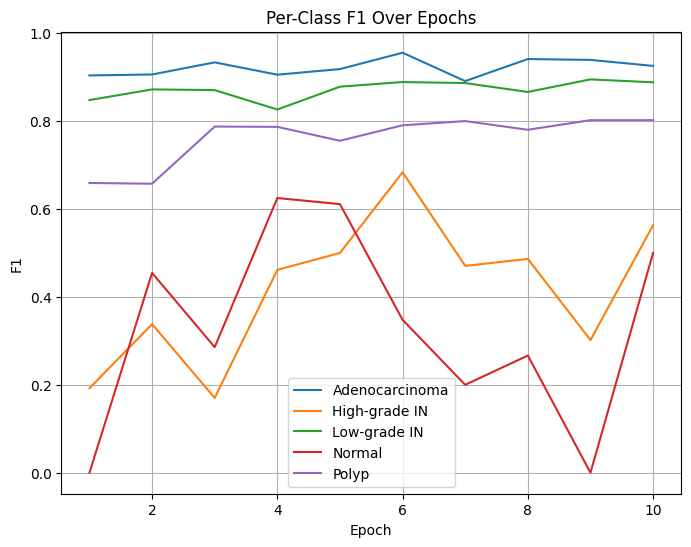

In [74]:
plot_per_class_metrics(history, class_names)

In [1]:
plot_confusion(y_true, y_pred, class_names)

NameError: name 'plot_confusion' is not defined

<h2 style="text-align: center;">Discussion</h2>